In [5]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import PIL.Image as Image

In [6]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [7]:
splits = tfds.Split.ALL.subsplit(weighted=(80,20))
(splits, info) = tfds.load("tf_flowers", with_info=True, as_supervised=True, split=splits)
(training_set, validation_set) = splits
num_examples = info.splits['train'].num_examples
print('Total Number of Images:', num_examples)

Total Number of Images: 3670


In [8]:
# We have to iterate over the training set to count its size
num_training_examples = 0
for i in iter(training_set):
    num_training_examples+=1
    
# The same goes for the validation set
num_validation_examples = 0
for i, img in iter(validation_set):
    num_validation_examples+=1
    
# The number of classes can just be grabbed from the info object
num_classes = info.features['label'].num_classes

print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {}'.format(num_validation_examples))
print('Total Number of Classes: {}'.format(num_classes))

Total Number of Training Images: 2950
Total Number of Validation Images: 720
Total Number of Classes: 5


In [5]:
for i, example in enumerate(training_set.take(5)):
    print('Image {} shape: {} label: {}'.format(i+1,example[0].shape, example[1]))

Image 1 shape: (332, 500, 3) label: 3
Image 2 shape: (213, 320, 3) label: 0
Image 3 shape: (333, 500, 3) label: 0
Image 4 shape: (240, 180, 3) label: 3
Image 5 shape: (333, 500, 3) label: 0


In [6]:
IMAGE_RES = 224
BATCH_SIZE = 32

In [8]:
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.
    return image, label

train_batches = training_set.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [9]:
URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [10]:
feature_extractor.trainable = False

In [11]:
L = [
    feature_extractor,
    tf.keras.layers.Dense(units=num_classes, activation='softmax')
]
model = tf.keras.Sequential(L)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
EPOCHS = 2
history = model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

Epoch 1/2
93/93 [==============================] - 57s 615ms/step - loss: 0.7316 - accuracy: 0.7329 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/2
93/93 [==============================] - 54s 583ms/step - loss: 0.3558 - accuracy: 0.8959 - val_loss: 0.3758 - val_accuracy: 0.8708


Text(0.5, 1.0, 'Training and Validation Loss')

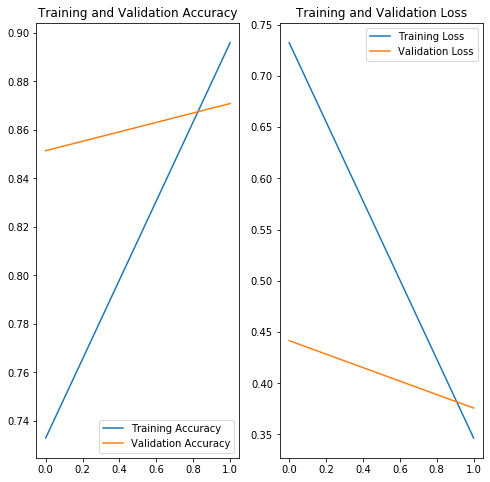

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [37]:
# Important: convert to NumPy array to enable fancy indexing
class_names = np.array(info.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [39]:
image_batch, label_batch = next(iter(train_batches.take(1)))

predicted_batch = model.predict(image_batch)
#predicted_batch = predicted_batch.numpy()

predicted_ids = np.argmax(predicted_batch, axis=1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

['sunflowers' 'tulips' 'dandelion' 'dandelion' 'tulips' 'roses' 'tulips'
 'dandelion' 'tulips' 'tulips' 'roses' 'dandelion' 'dandelion' 'dandelion'
 'sunflowers' 'daisy' 'roses' 'roses' 'tulips' 'dandelion' 'dandelion'
 'roses' 'roses' 'dandelion' 'sunflowers' 'sunflowers' 'roses'
 'sunflowers' 'daisy' 'sunflowers' 'daisy' 'sunflowers']


In [42]:
print(class_names[label_batch])

['sunflowers' 'tulips' 'dandelion' 'dandelion' 'tulips' 'roses' 'tulips'
 'dandelion' 'tulips' 'tulips' 'tulips' 'dandelion' 'dandelion'
 'dandelion' 'sunflowers' 'daisy' 'roses' 'roses' 'tulips' 'dandelion'
 'dandelion' 'roses' 'roses' 'dandelion' 'sunflowers' 'sunflowers' 'roses'
 'sunflowers' 'daisy' 'sunflowers' 'daisy' 'sunflowers']


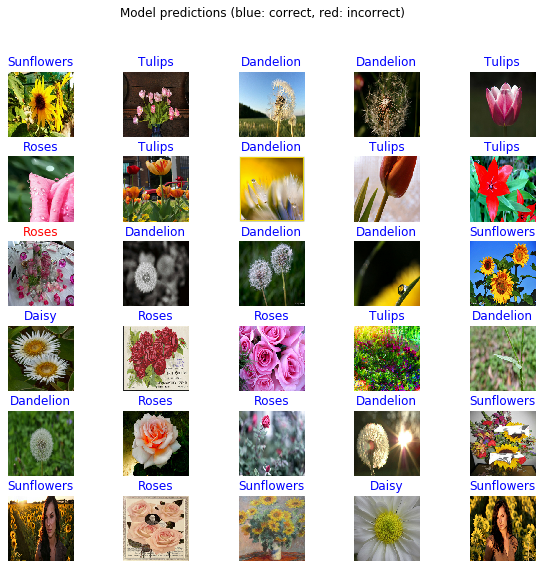

In [43]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [47]:
INCEPTION_URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
INC_IMAGE_RES = 299
feature_extractor = hub.KerasLayer(INCEPTION_URL, input_shape=(INC_IMAGE_RES, INC_IMAGE_RES, 3))

In [48]:
feature_extractor.trainable = False

In [54]:
def format_image(image, label):
    image = tf.image.resize(image, (INC_IMAGE_RES, INC_IMAGE_RES)) / 255.
    return image, label

train_batches = training_set.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [55]:
L = [
    feature_extractor,
    tf.keras.layers.Dense(units=num_classes, activation='softmax')
]
model = tf.keras.Sequential(L)

In [56]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [57]:
EPOCHS = 2
history = model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

Epoch 1/2
93/93 [==============================] - 211s 2s/step - loss: 0.6729 - accuracy: 0.7675 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/2
93/93 [==============================] - 212s 2s/step - loss: 0.3710 - accuracy: 0.8871 - val_loss: 0.3526 - val_accuracy: 0.8750


Text(0.5, 1.0, 'Training and Validation Loss')

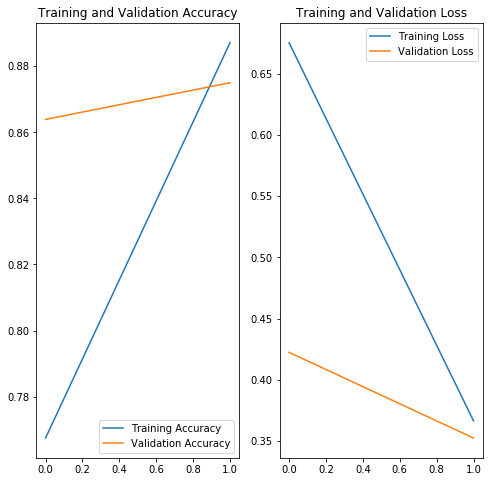

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [65]:
image_batch, label_batch = next(iter(train_batches.take(1)))
predicted_batch = model.predict(image_batch)

predicted_ids = np.argmax(predicted_batch, axis=1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

['tulips' 'daisy' 'sunflowers' 'dandelion' 'daisy' 'dandelion' 'roses'
 'sunflowers' 'sunflowers' 'sunflowers' 'daisy' 'roses' 'dandelion'
 'roses' 'sunflowers' 'sunflowers' 'roses' 'daisy' 'dandelion' 'tulips'
 'roses' 'tulips' 'dandelion' 'tulips' 'roses' 'dandelion' 'dandelion'
 'sunflowers' 'tulips' 'roses' 'sunflowers' 'roses']


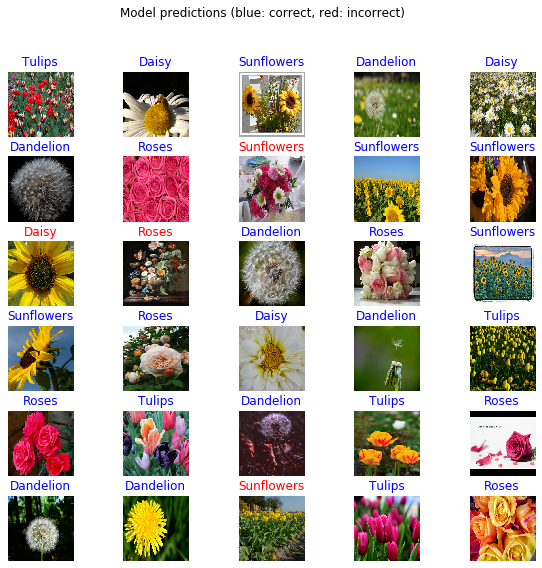

In [66]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")